# 6-1. 프로젝트: 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 `imdb.data_loader()` 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 `word_to_index` 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 `imdb.data_loader()`와 동일하게 동작하는 자신만의 `data_loader`를 만들어 보는 것으로 시작합니다. `data_loader` 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전`word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab(dicpath='/usr/local/lib/mecab/dic/mecab-ko-dic')
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def preprocess_sentence(batch_data, focus_col, stopword_list):
    batch_data.drop_duplicates(subset=[focus_col], inplace=True)
    batch_data.dropna(how='any', inplace=True)  # Corrected to operate on the passed batch_data
    
    processed_sentences = []  # Initialize a list to collect processed sentences
    for sentence in batch_data[focus_col]:
        tokens = tokenizer.morphs(sentence)  # 토큰화
        tokens = [word for word in tokens if word not in stopword_list]  # 불용어 제거
        processed_sentences.append(tokens)
    return processed_sentences  # Return all processed sentences

def load_data(train_data, test_data, num_words=10000):
    X_train = preprocess_sentence(train_data, 'document', stopwords)  # Process all training data
    X_test = preprocess_sentence(test_data, 'document', stopwords)  # Process all test data

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)
    vocab = ['<PAD>', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
---

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
print(len(X_test))

2022


In [7]:
print(index_to_word)

{0: '<PAD>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105: '냐', 106: '재미없', 107: '

[ 문장의 길이 분포 ] (길이: 개수)
1: 34
2: 28
3: 61
4: 66
5: 97
6: 123
7: 134
8: 134
9: 132
10: 102
11: 89
12: 79
13: 72
14: 78
15: 77
16: 63
17: 72
18: 54
19: 42
20: 48
21: 37
22: 27
23: 26
24: 20
25: 17
26: 21
27: 12
28: 20
29: 11
30: 20
31: 8
32: 11
33: 8
34: 7
35: 10
36: 12
37: 8
38: 8
39: 8
40: 7
41: 6
42: 7
43: 5
44: 7
45: 5
46: 10
47: 7
48: 7
49: 6
50: 6
51: 2
52: 6
53: 4
54: 9
55: 9
56: 5
57: 5
58: 5
59: 2
60: 2
61: 2
62: 5
63: 2
64: 6
66: 5
67: 2
72: 1
74: 1


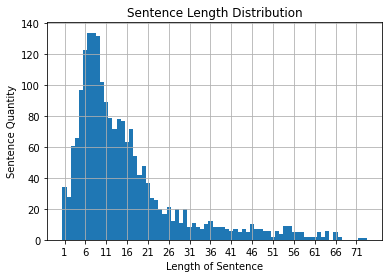

In [8]:
import matplotlib.pyplot as plt

def draw_histogram_of_dataset(type=0):
    # 각 문장의 길이 계산 및 카운트
    length_counts = Counter(len(arr) for arr in X_test)
    
    min_length = min(length_counts.keys())
    max_length = max(length_counts.keys())
    
    if type != 0:  # -- 이후 실험을 위한 조건문
        if min_length == max_length:
            print("모든 문장의 길이(구성 요소 개수) 동일")
            return
    
    # 분포 출력
    print("[ 문장의 길이 분포 ] (길이: 개수)")
    for length, count in sorted(length_counts.items()):
        print(f"{length}: {count}")
    
    # 히스토그램 그리기
    # 최소 길이와 최대 길이를 기준으로 적절한 bin 사이즈 설정
    bin_size = (max_length - min_length) // 50  # 50개의 구간으로 나누어 시각화

    plt.hist(length_counts.keys(), weights=length_counts.values(), bins=range(min_length, max_length + bin_size, bin_size), align='left')
    plt.xlabel('Length of Sentence')
    plt.ylabel('Sentence Quantity')
    plt.title('Sentence Length Distribution')
    plt.xticks(range(min_length, max_length + 1, bin_size * 5))  # x축 눈금을 적절히 조절
    plt.grid(True)
    plt.show()

draw_histogram_of_dataset()

In [9]:
length_counts = Counter(len(arr) for arr in X_test)
print(max(length_counts.values()), max(length_counts.items()))

134 (74, 1)


In [10]:
maxlen=134

In [11]:
print(list(word_to_index.keys()))

['<PAD>', '', '.', '영화', '다', '고', '하', '을', '보', '..', '게', ',', '!', '지', '있', '없', '?', '좋', '나', '었', '만', '는데', '너무', '봤', '적', '안', '정말', '로', '음', '것', '아', '네요', '재밌', '어', '같', '점', '지만', '진짜', '했', '에서', '기', '네', '않', '거', '았', '수', '되', '면', 'ㅋㅋ', '말', '연기', '인', '주', '내', '최고', '~', '평점', '이런', '던', '어요', '할', '왜', '겠', '1', '스토리', '해', '습니다', 'ㅋㅋㅋ', '...', '드라마', '생각', '아니', '더', '그', '싶', '사람', '듯', '때', '감동', '함', '배우', '본', '까지', '뭐', '알', '만들', '내용', '볼', '감독', '보다', '라', '그냥', '재미', '시간', '지루', '중', '재미있', '년', '10', '였', '잼', '사랑', '못', '냐', '재미없', '쓰레기', '서', '2', '라고', '야', '니', '면서', '번', '다시', '나오', '작품', '이거', '하나', '줄', '해서', '개', '남', '정도', '마지막', '끝', '이건', '액션', '임', 'ㅋ', '3', '기대', '입니다', '건', '라는', '분', '완전', '다는', '참', '많', '처음', '장면', '대', '아깝', '다가', '으면', '지금', '모르', '이렇게', "'", '편', '일', '돈', '이게', '성', '느낌', '시', '이야기', '최악', '된', '봐도', '님', '어서', '애', '전', '넘', 'ㅠㅠ', '인데', '다고', '이해', '별로', '그리고', '명작', '여자', '^^', '역시', '난', '이상', '또', '걸', '한국', 

In [12]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [13]:
draw_histogram_of_dataset()

[ 문장의 길이 분포 ] (길이: 개수)
134: 2022


ValueError: range() arg 3 must not be zero

위 오류는 좋은 신호이다. 오류 내용을 보면 `range()`의 세 번째 인자로 0을 넘기면 안 된다고 되어 있다. 즉, `bin_size`가 0임을 뜻하며, 이는 곧 `min_length`와 `max_length`가 동일하기에 가능하다. 패딩이 잘 되었음을 알리는 신호이다.
이를 아래를 통해 더 명시적으로 확인할 수 있다.

In [14]:
draw_histogram_of_dataset(type=1)

모든 문장의 길이(구성 요소 개수) 동일


In [15]:
print(X_train)  # 패딩이 채워진 모습 출력

[[   0    0    0 ...   20   33  748]
 [   0    0    0 ...   15   44  391]
 [   0    0    0 ...   24  205    3]
 ...
 [   0    0    0 ... 2710    6   18]
 [   0    0    0 ...   60  395 8572]
 [   0    0    0 ...   88 2740    5]]


In [16]:
vocab_size = len(word_to_index)
word_vector_dim = 10  # 워드 벡터 차원 (실험 요)

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

output = embedding(X_train)
print(output)

tf.Tensor(
[[[-0.0255899   0.01040263 -0.00167651 ...  0.02432087 -0.00619001
    0.01984862]
  [-0.0255899   0.01040263 -0.00167651 ...  0.02432087 -0.00619001
    0.01984862]
  [-0.0255899   0.01040263 -0.00167651 ...  0.02432087 -0.00619001
    0.01984862]
  ...
  [ 0.01177939 -0.0041793   0.02475227 ...  0.03845123 -0.01515578
    0.01490035]
  [ 0.04646615  0.01390535  0.00050063 ...  0.01418241 -0.03710418
   -0.02186573]
  [ 0.0303109   0.03531292 -0.01284779 ...  0.04780794  0.02513463
    0.01116204]]

 [[-0.0255899   0.01040263 -0.00167651 ...  0.02432087 -0.00619001
    0.01984862]
  [-0.0255899   0.01040263 -0.00167651 ...  0.02432087 -0.00619001
    0.01984862]
  [-0.0255899   0.01040263 -0.00167651 ...  0.02432087 -0.00619001
    0.01984862]
  ...
  [-0.00286374 -0.01573469  0.03278149 ...  0.02717948  0.0359712
    0.0286731 ]
  [-0.00408489  0.02306929 -0.02687101 ...  0.03543431  0.0463781
   -0.02369627]
  [-0.02973045  0.01338739 -0.0431792  ...  0.04457707 -0.017244

In [17]:
# 노드에서 사용한 LSTM 구조
model_lstm_1 = tf.keras.Sequential()
model_lstm_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_1.add(tf.keras.layers.LSTM(8))
model_lstm_1.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          99980     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 100,669
Trainable params: 100,669
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_lstm_2 = tf.keras.Sequential()
model_lstm_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_2.add(tf.keras.layers.LSTM(8))
model_lstm_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm_2.add(tf.keras.layers.Dense(1, activation='softmax'))  # model_1에 비해 활성화 함수만 변경

model_lstm_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          99980     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 100,669
Trainable params: 100,669
Non-trainable params: 0
_________________________________________________________________


## 4) validation set 구성 및 모델 구성

In [19]:
# validation set을 위한 분리량 결정
val_size = int(len(X_test) * 0.2)
val_size

404

In [20]:
# validation set
X_val = X_train[:val_size]   
y_val = y_train[:val_size]

# validation set을 제외한 나머지
partial_x_train = X_train[val_size:]  
partial_y_train = y_train[val_size:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(145778, 134)
(145778,)


In [21]:
model_lstm_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model_lstm_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 5) 모델 훈련 개시

In [23]:
epochs=20  # 노드에서 사용한 값 - 20

history_lstm_1 = model_lstm_1.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=epochs,
                                  batch_size=512,
                                  validation_data=(X_val, y_val),
                                  verbose=1)

Epoch 1/20
285/285 [==============================] - 6s 9ms/step - loss: 0.5615 - accuracy: 0.7346 - val_loss: 0.4193 - val_accuracy: 0.8465
Epoch 2/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3635 - accuracy: 0.8510 - val_loss: 0.3511 - val_accuracy: 0.8465
Epoch 3/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3251 - accuracy: 0.8644 - val_loss: 0.3362 - val_accuracy: 0.8663
Epoch 4/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3122 - accuracy: 0.8709 - val_loss: 0.3356 - val_accuracy: 0.8688
Epoch 5/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3040 - accuracy: 0.8756 - val_loss: 0.3418 - val_accuracy: 0.8564
Epoch 6/20
285/285 [==============================] - 2s 8ms/step - loss: 0.2962 - accuracy: 0.8792 - val_loss: 0.3402 - val_accuracy: 0.8614
Epoch 7/20
285/285 [==============================] - 2s 8ms/step - loss: 0.2893 - accuracy: 0.8827 - val_loss: 0.3350 - val_accuracy: 0.8614
Epoch 

In [24]:
results = model_lstm_1.evaluate(X_test,  y_test, verbose=2)

print(results)

64/64 - 1s - loss: 0.3960 - accuracy: 0.8595
[0.39598333835601807, 0.8595449924468994]


In [25]:
history_dict_1 = history_lstm_1.history
print(history_dict_1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


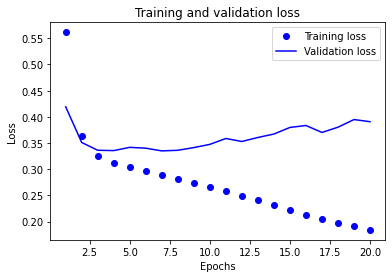

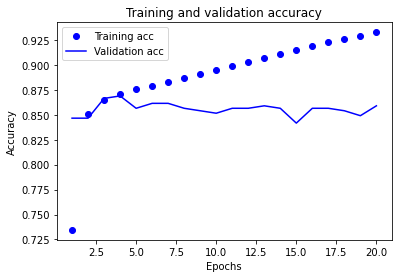

In [27]:
import matplotlib.pyplot as plt

def plot_loss_and_metric(fit_history: tf.keras.callbacks.History):
    history_dict = fit_history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    plt.clf()   # 그림 초기화 ()

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_loss_and_metric(fit_history=history_lstm_1)

In [28]:
epochs=20  # 노드에서 사용한 값 - 20

history_lstm_2 = model_lstm_2.fit(partial_x_train,
                                  partial_y_train,
                                  epochs=epochs,
                                  batch_size=512,
                                  validation_data=(X_val, y_val),
                                  verbose=1)

Epoch 1/20
285/285 [==============================] - 4s 9ms/step - loss: 0.4872 - accuracy: 0.4983 - val_loss: 0.3581 - val_accuracy: 0.4975
Epoch 2/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3387 - accuracy: 0.4983 - val_loss: 0.3417 - val_accuracy: 0.4975
Epoch 3/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3200 - accuracy: 0.4983 - val_loss: 0.3378 - val_accuracy: 0.4975
Epoch 4/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3102 - accuracy: 0.4983 - val_loss: 0.3357 - val_accuracy: 0.4975
Epoch 5/20
285/285 [==============================] - 2s 8ms/step - loss: 0.3017 - accuracy: 0.4983 - val_loss: 0.3387 - val_accuracy: 0.4975
Epoch 6/20
285/285 [==============================] - 2s 8ms/step - loss: 0.2948 - accuracy: 0.4983 - val_loss: 0.3336 - val_accuracy: 0.4975
Epoch 7/20
285/285 [==============================] - 2s 8ms/step - loss: 0.2879 - accuracy: 0.4983 - val_loss: 0.3411 - val_accuracy: 0.4975
Epoch 

In [29]:
results = model_lstm_2.evaluate(X_test,  y_test, verbose=2)

print(results)

64/64 - 1s - loss: 0.4317 - accuracy: 0.5129
[0.4317269027233124, 0.5128585696220398]


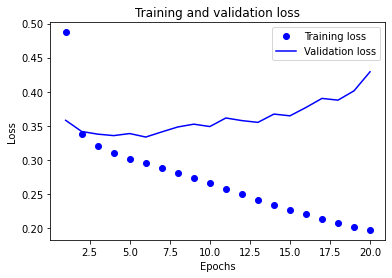

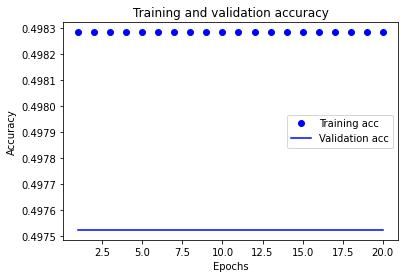

In [30]:
# model_lstm_1 과 달리 출력층에 softmaz 사용 모델의 기록
plot_loss_and_metric(fit_history=history_lstm_2)

## 7) 학습된 Embedding 레이어 분석

In [31]:
embedding_layer = model_lstm_1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(9998, 10)


In [32]:
weights

array([[-0.02678843,  0.02748658,  0.00217963, ...,  0.10027806,
        -0.07552894, -0.05408679],
       [ 0.00155356, -0.0251424 , -0.01234249, ..., -0.0029287 ,
        -0.00803499, -0.01067387],
       [-0.02221762,  0.01571201, -0.04670229, ...,  0.02078633,
        -0.03173481, -0.02961047],
       ...,
       [-0.09780365, -0.19942603, -0.12662888, ...,  0.00068718,
         0.256037  , -0.12395096],
       [ 0.1018906 ,  0.06322756,  0.09875364, ..., -0.09591795,
        -0.09624769,  0.05038649],
       [ 0.2056031 ,  0.20381422,  0.24272604, ..., -0.27110562,
        -0.01661234,  0.03926988]], dtype=float32)

## 8) 성능 개선 - 한국어 Word2Vec 임베딩 활용

In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm_1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['안녕']
vector

array([ 0.01793068,  0.03156793,  0.06745593,  0.04885247, -0.11715543,
       -0.01974576,  0.02364203, -0.00779991, -0.01133046,  0.04340003],
      dtype=float32)

In [35]:
word_vectors.similar_by_word("사랑")

[('마이클', 0.9643052816390991),
 ('평행', 0.9605814218521118),
 ('이민정', 0.9551293849945068),
 ('천재', 0.9539595246315002),
 ('곡', 0.95098876953125),
 ('자격', 0.9507306218147278),
 ('고인', 0.9487102031707764),
 ('질까', 0.9484605193138123),
 ('릿', 0.9477466940879822),
 ('살아가', 0.9450260400772095)]

In [36]:
from gensim.models import KeyedVectors

word2vec_path = './data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [37]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [38]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [39]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 134, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 16)           33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 16)            1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [40]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_word2vec = model.fit(partial_x_train,
                             partial_y_train,
                             epochs=epochs,
                             batch_size=512,
                             validation_data=(X_val, y_val),
                             verbose=1)

Epoch 1/20
285/285 [==============================] - 7s 17ms/step - loss: 0.6209 - accuracy: 0.6327 - val_loss: 0.4977 - val_accuracy: 0.7500
Epoch 2/20
285/285 [==============================] - 4s 16ms/step - loss: 0.4393 - accuracy: 0.7898 - val_loss: 0.4614 - val_accuracy: 0.7698
Epoch 3/20
285/285 [==============================] - 4s 16ms/step - loss: 0.3986 - accuracy: 0.8133 - val_loss: 0.4592 - val_accuracy: 0.7723
Epoch 4/20
285/285 [==============================] - 4s 16ms/step - loss: 0.3740 - accuracy: 0.8258 - val_loss: 0.4651 - val_accuracy: 0.7896
Epoch 5/20
285/285 [==============================] - 5s 16ms/step - loss: 0.3534 - accuracy: 0.8376 - val_loss: 0.4680 - val_accuracy: 0.7748
Epoch 6/20
285/285 [==============================] - 5s 16ms/step - loss: 0.3314 - accuracy: 0.8488 - val_loss: 0.4882 - val_accuracy: 0.7797
Epoch 7/20
285/285 [==============================] - 5s 16ms/step - loss: 0.3069 - accuracy: 0.8617 - val_loss: 0.4988 - val_accuracy: 0.7723

In [41]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

64/64 - 0s - loss: 0.9123 - accuracy: 0.7591
[0.9122552275657654, 0.7591493725776672]


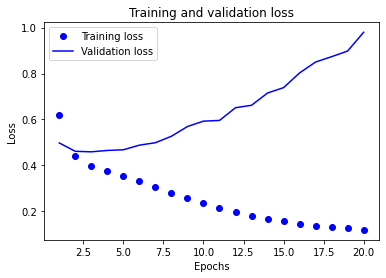

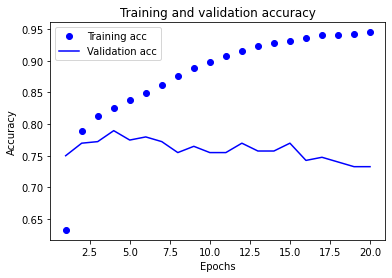

In [42]:
plot_loss_and_metric(fit_history=history_word2vec)